In [1]:
!pip install gpytorch
!pip install optuna

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [29]:
import torch
import gpytorch
from gpytorch.models import ExactGP
from gpytorch.means import ConstantMean
from gpytorch.kernels import ScaleKernel, RBFKernel
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.mlls import ExactMarginalLogLikelihood
from sklearn.model_selection import StratifiedKFold
import numpy as np
import gc


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Data Preprocessing

In [1]:
import pandas as pd
import time
import numpy as np
from helper_functions.preprocessing_functions import filter_targets_on_quantile, get_feature_length, filter_for_low_variance

In [3]:
## Do some preprocessing which is universal to all models
df = pd.read_parquet("data/Seeds/60_features_CSS.gz")

In [5]:
feature_length = 60

In [6]:
# filter out relevant microorganism from initial +10K individual species
# step1: remove all zero abundance microbes based on quantile
quantile = 0.85 #this can be modified
df_red = filter_targets_on_quantile(df, feature_length, quantile)
# step2: only keep low variance microbes
cv = 0.2 # this can be modified, 0.5 for paper
df_red, microbes_left = filter_for_low_variance(df, df_red, feature_length, cv)
print("Number Microbes left:", len(microbes_left))

Number Microbes left: 179


In [7]:
df_red.shape

(1179, 239)

In [8]:
def set_hold_out_set(df, hold_out_species, feature_length):
  """
  This function sets the hold out set.
  """
  df_ = df.copy()
  # remove the hold out species from the distance matrix columns
  df_.drop(columns=[hold_out_species], inplace=True)
  # removing the  hold out  species from the row data
  # first assign it to the hold_out_set
  hold_out_set = df_.loc[[hold_out_species]]
  # removing the hold out species from the data
  df_.drop(df_.loc[[hold_out_species]].index, inplace=True)
  return df_, hold_out_set

In [9]:
# setting the hold out set
# in this case we use Oryza alta as the hold out species
data, hold_out_set = set_hold_out_set(df_red, "Oryza alta", feature_length)

In [11]:
# Splitting the dataframe into features and targets
X = data.iloc[:, :(feature_length-1 )]
Y = data.iloc[:, (feature_length-1 ):]
print("X-shape:", X.shape)
print("Y-shape:", Y.shape)

# do same for hold out set
X_hold_out = hold_out_set.iloc[:, :(feature_length-1)]
Y_hold_out = hold_out_set.iloc[:, (feature_length-1):]
print("X_hold_out-shape:", X_hold_out.shape)
print("Y_hold_out-shape:", Y_hold_out.shape)

X-shape: (1178, 59)
Y-shape: (1178, 179)
X_hold_out-shape: (1, 59)
Y_hold_out-shape: (1, 179)


## Begin GPR Model Definition

In [14]:
class BatchIndependentMultitaskGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, batch_shape_):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean(batch_shape=batch_shape_)
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(batch_shape=batch_shape_),
            batch_shape=batch_shape_)


    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultitaskMultivariateNormal.from_batch_mvn(
            gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
        )

In [ ]:
def train_full_gp(train_x, train_y, X_hold_out, length_scale):
    num_tasks_ = train_y.shape[-1]
    batch_shape_y = torch.Size([train_y.shape[-1]])

    # Convert your dataframes to PyTorch tensors
    X_tensor = torch.tensor(train_x.values, dtype=torch.float32)
    Y_tensor = torch.tensor(train_y.values, dtype=torch.float32)
    X_test = torch.tensor(X_hold_out.values, dtype=torch.float32)


    # Move data to the selected device
    X_tensor = X_tensor.to(device)
    Y_tensor = Y_tensor.to(device)
    X_test = X_test.to(device)
    print(X_tensor.shape)
    print(Y_tensor.shape)
    print(X_test.shape)
    print(num_tasks_)
    print(batch_shape_y)

    # Initialize the model and likelihood
    likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=num_tasks_).to(device)
    model = BatchIndependentMultitaskGPModel(X_tensor, Y_tensor, likelihood, batch_shape_y).to(device)
    model.covar_module.base_kernel.lengthscale = length_scale

    # Use the Adam optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    mll = ExactMarginalLogLikelihood(likelihood, model)

    # Training loop
    model.train()
    likelihood.train()

    for i in range(50):  # Number of iterations
        optimizer.zero_grad()
        output = model(X_tensor)
        loss = -mll(output, Y_tensor)
        assert loss.dim() == 0, "Loss is not a scalar"
        loss.backward()
        optimizer.step()

    # Evaluation
    model.eval()
    likelihood.eval()
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        preds = likelihood(model(X_test))
        mean = preds.mean

        # Get 95% confidence intervals
        lower, upper = preds.confidence_region()

    torch.cuda.empty_cache()  # Free unreferenced memory from the GPU
    gc.collect()
    return mean.cpu(), lower.cpu(), upper.cpu()

## Next Step: using baysian optimization for hyperparameter tuning

- parameters to tune: length_scale, output_scale, noise, lr, constant_mean


In [25]:
# Clear the cache
torch.cuda.empty_cache()

# Optionally, trigger garbage collection
gc.collect()

0

## Begin hyperparameter tuning

In [39]:
import optuna
import torch
import gpytorch
import gc
from sklearn.model_selection import KFold

class BatchIndependentMultitaskGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, batch_shape_):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean(batch_shape=batch_shape_)
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(batch_shape=batch_shape_),
            batch_shape=batch_shape_)

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultitaskMultivariateNormal.from_batch_mvn(
            gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
        )

def train_full_gp(train_x, train_y, X_hold_out, length_scale, output_scale, noise, lr, constant_mean):
    num_tasks_ = train_y.shape[-1]
    batch_shape_y = torch.Size([train_y.shape[-1]])

    # Convert your dataframes to PyTorch tensors
    X_tensor = torch.tensor(train_x.values, dtype=torch.float32)
    Y_tensor = torch.tensor(train_y.values, dtype=torch.float32)
    X_test = torch.tensor(X_hold_out.values, dtype=torch.float32)

    # Move data to the selected device
    X_tensor = X_tensor.to(device)
    Y_tensor = Y_tensor.to(device)
    X_test = X_test.to(device)

    # Initialize the model and likelihood
    likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=num_tasks_, noise_constraint=gpytorch.constraints.GreaterThan(1e-4)).to(device)
    likelihood.noise = noise

    model = BatchIndependentMultitaskGPModel(X_tensor, Y_tensor, likelihood, batch_shape_y).to(device)
    model.covar_module.base_kernel.lengthscale = length_scale
    model.covar_module.outputscale = output_scale
    model.mean_module.constant = constant_mean

    # Use the Adam optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    # Training loop
    model.train()
    likelihood.train()

    for i in range(50):  # Number of iterations
        optimizer.zero_grad()
        output = model(X_tensor)
        loss = -mll(output, Y_tensor)
        assert loss.dim() == 0, "Loss is not a scalar"
        loss.backward()
        optimizer.step()

    # Evaluation
    model.eval()
    likelihood.eval()
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        preds = likelihood(model(X_test))
        mean = preds.mean

        # Get 95% confidence intervals
        lower, upper = preds.confidence_region()

    # Move tensors to CPU before returning
    mean_cpu = mean.cpu()
    lower_cpu = lower.cpu()
    upper_cpu = upper.cpu()

    torch.cuda.empty_cache()  # Free unreferenced memory from the GPU
    gc.collect()
    return mean_cpu, lower_cpu, upper_cpu



In [49]:
def objective(trial):
    length_scale = trial.suggest_float('length_scale', 0.1, 10.0)
    output_scale = trial.suggest_float('output_scale', 0.1, 10.0)
    noise = trial.suggest_float('noise', 1e-4, 1.0, log=True)
    lr = trial.suggest_float('lr', 1e-4, 1e-1, log=True)
    constant_mean = trial.suggest_float('constant_mean', -1.0, 1.0)

    kf = KFold(n_splits=5)
    val_losses = []

    for train_index, val_index in kf.split(X):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        Y_train, Y_val = Y.iloc[train_index], Y.iloc[val_index]

        mean_, lower_, upper_ = train_full_gp(X_train, Y_train, X_val, length_scale, output_scale, noise, lr, constant_mean)

        # Move mean_ to CPU
        mean_cpu = mean_.cpu()
        Y_val_tensor = torch.tensor(Y_val.values, dtype=torch.float32) # Create Y_val tensor on CPU
        val_loss = torch.mean((mean_cpu - Y_val_tensor) ** 2)
        val_losses.append(val_loss.item())

    return np.mean(val_losses)

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)




[I 2024-08-20 13:33:27,263] A new study created in memory with name: no-name-0565a847-65e6-4684-8ace-67c6c896b87a
[I 2024-08-20 13:34:46,402] Trial 0 finished with value: 1.1252270102500916 and parameters: {'length_scale': 8.066048082372111, 'output_scale': 4.08552050665754, 'noise': 0.025894608670580344, 'lr': 0.0011636736185890988, 'constant_mean': -0.8944082710279386}. Best is trial 0 with value: 1.1252270102500916.
[I 2024-08-20 13:36:06,025] Trial 1 finished with value: 1.1291286587715148 and parameters: {'length_scale': 8.393967307982413, 'output_scale': 1.6894851580067745, 'noise': 0.05291218167235317, 'lr': 0.0007867678143924076, 'constant_mean': -0.42111311265522455}. Best is trial 0 with value: 1.1252270102500916.
[I 2024-08-20 13:37:26,497] Trial 2 finished with value: 1.098106038570404 and parameters: {'length_scale': 0.46045811161485717, 'output_scale': 0.12521652276794856, 'noise': 0.0006554816464831237, 'lr': 0.006577786151727863, 'constant_mean': 0.43886115962074546}. B

In [48]:
mean_.device

device(type='cuda', index=0)

In [50]:
best_params = study.best_params
print("Best hyperparameters: ", best_params)

# Train the final model with the best hyperparameters
mean_, lower_, upper_ = train_full_gp(X, Y, X_hold_out,
                                      length_scale=best_params['length_scale'],
                                      output_scale=best_params['output_scale'],
                                      noise=best_params['noise'],
                                      lr=best_params['lr'],
                                      constant_mean=best_params['constant_mean'])

Best hyperparameters:  {'length_scale': 0.46045811161485717, 'output_scale': 0.12521652276794856, 'noise': 0.0006554816464831237, 'lr': 0.006577786151727863, 'constant_mean': 0.43886115962074546}


In [53]:
# collecting the mean_, lower_, upper_ convert them to array and store them in a dataframe, using the columns of the X_hold_out as an idex

# Convert tensors to NumPy arrays and flatten
mean_array = mean_.cpu().numpy().flatten()
lower_array = lower_.cpu().numpy().flatten()
upper_array = upper_.cpu().numpy().flatten()

# Create a DataFrame using the columns of X_hold_out as index
predictions_df = pd.DataFrame({
    'mean': mean_array,
    'lower': lower_array,
    'upper': upper_array
}, index=Y_hold_out.columns)

predictions_df.to_csv(f"./predictions_first_tuning.csv")

In [60]:
predictions_df

,mean,lower,upper
a5ef3b247040efb6740742b1b39ab650,0.016566,-1.815266,1.848398
1c6313722e5a47b87cd83f098e24ec53,0.005436,-1.696671,1.707543
78a3f4075f107d2b228edaedfd145509,0.004919,-1.594385,1.604223
cb3383a83112a282e77260cd6437dd09,0.030105,-1.566715,1.626926
6c5f4f9666d82b1bedf94e99acfe6741,0.020160,-1.718545,1.758865
...,...,...,...
e58635da024cba851c640eb384bc8fad,0.109068,-1.581253,1.799389
f968254345bd05c204aee9646945cfa0,0.009552,-1.587785,1.606889
70a60612f186462ac3e8cd7ffb50690c,0.045076,-1.560128,1.650280
fcefcf8251a90f53683d1e0e455c096d,0.040700,-1.848821,1.930222


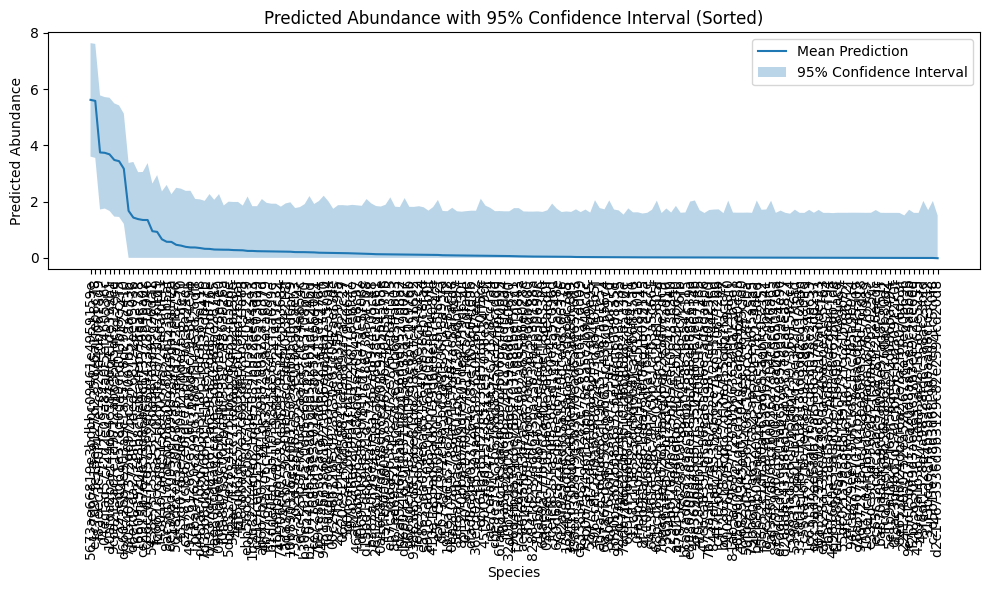

In [62]:
# plotting a confidence interval with the mean and lower + upper ranges, sorted according to decreasing values of the mean prediction column
# Also, we need to clip the lowest possible values to 0 (negative values do not make sense)

import matplotlib.pyplot as plt

# Sort the predictions DataFrame by mean in descending order
predictions_df_sorted = predictions_df.sort_values('mean', ascending=False)

# Clip the lower bound to 0
predictions_df_sorted['lower'] = predictions_df_sorted['lower'].clip(lower=0)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(predictions_df_sorted.index, predictions_df_sorted['mean'], label='Mean Prediction')
plt.fill_between(predictions_df_sorted.index, predictions_df_sorted['lower'], predictions_df_sorted['upper'], alpha=0.3, label='95% Confidence Interval')
plt.xlabel('Species')
plt.ylabel('Predicted Abundance')
plt.title('Predicted Abundance with 95% Confidence Interval (Sorted)')
plt.xticks(rotation=90)
plt.legend()
plt.tight_layout()
plt.show()
